<a href="https://colab.research.google.com/github/hgaiji/GoogleColab/blob/main/auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
#　パッケージのimport
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist


In [41]:
#  ハイパラメータの設定
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [42]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# # エンコーダの生成
# x = Input(shape=(original_dim),name="input")
# # 中間層
# h = Dense(intermediate_dim, activation="relu", name="encoding")(x)
# #潜在空間の平均　mean を定義
# z_mean = Dense(latent_dim, name="mean")(h)
# print(z_mean)
# # 潜在空間でのlog分散(log variance)を定義
# z_log_var = Dense(latent_dim, name="log-variance")(h)

# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# encoder = Model(x, [z_mean, z_log_var, z], name="encoder")

# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

In [43]:
# # デコーダーの記述
# input_decoder = Input(shape=(latent_dim,), name="decorder=input")
# #潜在空間から途中の次元数にする
# decoder_h = Dense(intermediate_dim, activation='relu',name="decorder_h")(input_decoder)
# x_decoed = Dense(original_dim, activation='sigmoid',name="flat_decoded")(decoder_h)
# # デコーダーをkerasのモデルとして定義
# decoder = Model(input_decoder, x_decoed, name="decoder")
# decoder.summary()


# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [44]:
# # モデルをまとめる
# # 結果を得る　３つ目の要素はサンプリングされたｚです
# output_combined = decoder(encoder(x)[2])
# # 入力と全体の出力を結びつける
# vae = Model(x, output_combined)
# vae.summary()

# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [45]:

Model??

In [46]:

def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
            z_log_var=z_log_var, z_mean=z_mean,
            original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:

Model??

In [47]:
# 訓練データと検証用データの分離
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [50]:
vae.fit(x_train, x_train,shuffle=True,epochs=epochs,batch_size=batch_size)

Epoch 1/50


TypeError: ignored

(60000, 784)
(10000, 784)
Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.3789 - val_loss: 0.1865
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1784 - val_loss: 0.1534
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1492 - val_loss: 0.1335
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1312 - val_loss: 0.1204
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1197 - val_loss: 0.1122
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1123 - val_loss: 0.1065
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1069 - val_loss: 0.1027
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1028 - val_loss: 0.0993
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1002 - val_loss: 0.0971
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss:

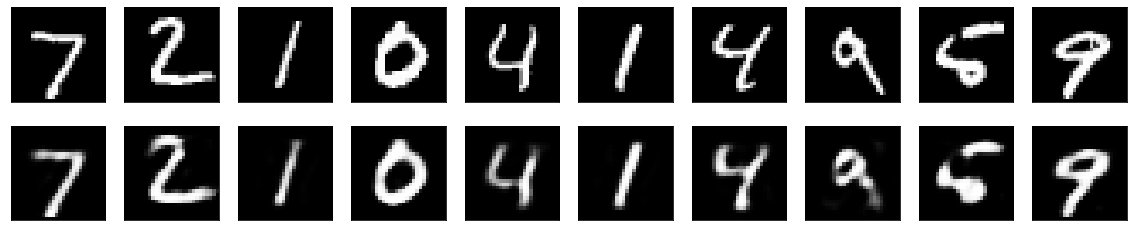

In [52]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
                               

                               # Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()